In [4]:
import matplotlib.pyplot as plt
import numpy as np

## Load data

<AxesSubplot:xlabel='phi', ylabel='psi'>

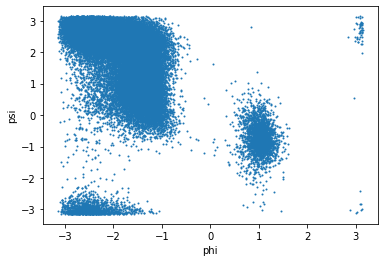

In [5]:
from stateinterpreter import load_dataframe

colvar = load_dataframe('alanine/COLVAR_DeepTICA')

colvar.plot.scatter('phi','psi',s=1)

## Compute descriptors

In [3]:
from stateinterpreter import load_trajectory
from stateinterpreter.descriptors import compute_descriptors

traj_dict = {
        'trajectory' : 'alanine/alanine.xtc',
        'topology' : 'alanine/input.ala2.pdb'
    }

traj = load_trajectory(traj_dict)
descriptors, feats_info = compute_descriptors( traj, descriptors = ['hbonds_contacts','dihedrals'] )

descriptors

Computing Hydrogen bonds contacts
Donors: [6, 16]
Acceptors: [ 5  6 15 16]
Descriptors: (50001, 10)


,HB_C ACE1-O -- ALA2-N,HB_C ACE1-O -- NME3-N,HB_C ALA2-N -- NME3-N,HB_C ALA2-O -- NME3-N,phi ACE1,sin_phi ACE1,cos_phi ACE1,psi ALA2,sin_psi ALA2,cos_psi ALA2
0,0.929044,0.100502,0.459074,0.930207,-2.368267,-0.698519,-0.715592,2.643943,0.477362,-0.878707
1,0.933527,0.260737,0.487284,0.934357,-1.818813,-0.969401,-0.245482,2.266428,0.767649,-0.640871
2,0.938087,0.183339,0.458683,0.942874,-1.962519,-0.924253,-0.381781,2.518990,0.583152,-0.812363
3,0.923064,0.237140,0.409412,0.943660,-1.546074,-0.999694,0.024719,2.609307,0.507504,-0.861649
4,0.941426,0.719332,0.687630,0.937150,-1.434391,-0.990711,0.135983,1.046329,0.865591,0.500752
...,...,...,...,...,...,...,...,...,...,...
49996,0.926837,0.085131,0.377203,0.933967,-2.707132,-0.420922,-0.907097,3.098981,0.042599,-0.999092
49997,0.927286,0.100841,0.408674,0.926865,-2.740673,-0.390265,-0.920702,-3.082756,-0.058803,-0.998270
49998,0.931873,0.205738,0.426683,0.930809,-1.793389,-0.975328,-0.220759,2.420310,0.660348,-0.750959
49999,0.928926,0.130366,0.427677,0.934629,-2.258257,-0.772860,-0.634577,2.640437,0.480439,-0.877028


## Hierarchical classification

/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/hierarchical.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logweight = logweights[[parent_mask]]
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:466: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)


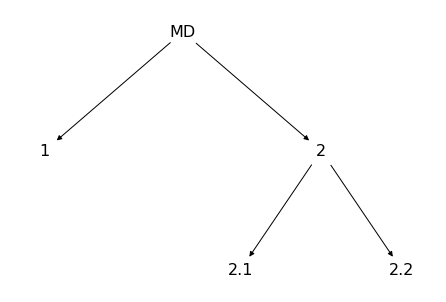

In [8]:
from stateinterpreter.utils.hierarchical import state_tree,hierarchy_pos,generate_state_labels_from_tree
import networkx as nx

cvs = colvar[['DeepTICA 1','DeepTICA 2']].values
bandwidth = 0.05

#weights
kbt = 2.5
logweight = colvar['opes.bias'].values/kbt

# build tree of metastable states
T = state_tree(cvs, bandwidth, logweights=logweight)

# draw tree
pos = hierarchy_pos(T)
options = {
    "with_labels": True,
    "font_size": 16,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "white",
    "linewidths": 1,
    "width": 1,
}

nx.draw(T, pos, **options)

In [11]:
# generate state_labels for classification
labels_list = generate_state_labels_from_tree(T, root='MD', fes_threshold=1 ) 

# example of labels 
labels_list[0]

,labels,selection
0,2,True
1,2,True
2,2,True
3,2,True
4,2,True
...,...,...
49996,2,True
49997,2,True
49998,2,True
49999,2,True


In [30]:
from stateinterpreter import identify_metastable_states,prepare_training_dataset,Classifier
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,plot_histogram_features
from stateinterpreter.utils.plot import paletteFessa,plot_fes
from stateinterpreter.utils.metrics import get_basis_quality,get_best_reg
from itertools import cycle

def train(cv_list,descriptors,states_labels=None,mask=None,merge_states=None,states_subset=None,color=None):
    # apply mask if given
    if mask is not None:
        cv = colvar[mask].reset_index()
        desc = descriptors[mask].reset_index()
        logw = None
        if logweights is not None:
            logw = logweights[mask]
            if type(logw) == pd.DataFrame:
                logw = logw.reset_index()
    else:
        cv = colvar
        desc = descriptors
        logw = logweights

    ### identify states if states_labels is None
    if states_labels is None:
        states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, logweights=logw, fes_cutoff=kBT, gradient_descent_iterates=gradient_descent_iterates)
    
    # merge states if requested 
    if merge_states is not None:
        for pair in merge_states:
            states_labels.loc[states_labels['labels'] == pair[1], 'labels'] = pair[0]
    
    # classify
    sample_obj, features_names = prepare_training_dataset(desc, states_labels, num_samples, regex_filter=select_feat , states_subset=states_subset) 
    classifier = Classifier(sample_obj, features_names)
    classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

    # get best reg
    reg,acc,num = get_best_reg(classifier)
    print(f'log_10 (lambda) : {np.round(np.log10(reg),3)}')
    print(f'Accuracy        : {np.round(acc*100,0)} %')
    print(f'No. features    : {num}')

    # get basis quality
    quality = get_basis_quality(classifier)
    print(f'Basis quality   : {quality} (lower the better)')

    # count states
    num_states = len(classifier.classes)
    num_histo = num_states if num_states>2 else 1
    
    # classes names
    relevant_feat = classifier.feature_summary(reg)
    classes_names = classifier.classes

    fig = plt.figure(figsize=(13.5,3), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(num_histo, 3, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[:, 1])
    axs_histo = []
    for i in range(num_histo):
        axs_histo.append(fig.add_subplot(gs[i, 2]))
    ax = ax1

    # COLOR 
    if color is None:
        colors = cycle(iter(paletteFessa[::-1]))
        global global_states_no 
        for i in range(global_states_no):
            next(colors)
        color = [next(colors) for i in range(5)]

    # PLOT FES
    cv_plot = cv [states_labels['labels'] != 'undefined']
    logw_plot=None
    if logw is not None:
        logw_plot = logw[states_labels['labels'] != 'undefined']
    plot_fes(cv_plot[cv_list],bandwidth,states_labels,logweights=logw_plot,num_samples=200,states_subset=states_subset,ax=ax, colors=color)

    # plot classfier
    ax = ax2
    _, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
    ax.axvline(np.log10(reg),linestyle='dotted',color='k')
    ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
    ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

    #print features
    classifier.print_selected(reg)
    
    plot_histogram_features(desc, states_labels, classes_names, relevant_feat, axs = axs_histo, height=1, colors=color)

    # INCREASE COUNTER
    global_states_no += num_states

    return (cv_list,states_labels,features_names,classifier,reg)

In [ ]:
# HBONDS
feat_type = 'hbonds'
select_feat = 'HB_C'
filter_descriptors = False 

# Select only contacts which are greater than 0.5 at least once for these states
if filter_descriptors:
    selected = ((descriptors.filter(regex=select_feat)>0.5).sum()>0)
    desc = descriptors[selected.index[selected]]
    print('Filtering H-bonds:',desc.shape)
else:
    desc = descriptors.filter(regex=select_feat)
    print('Descriptors:',desc.shape)
    
desc.head()

In [31]:
# ANGLES
feat_type = 'angles'
select_feat = 'sin_|cos_'

desc = descriptors.filter(regex=select_feat)
print('Descriptors:',desc.shape)
desc.head()

Descriptors: (50001, 4)


,sin_phi ACE1,cos_phi ACE1,sin_psi ALA2,cos_psi ALA2
0,-0.698519,-0.715592,0.477362,-0.878707
1,-0.969401,-0.245482,0.767649,-0.640871
2,-0.924253,-0.381781,0.583152,-0.812363
3,-0.999694,0.024719,0.507504,-0.861649
4,-0.990711,0.135983,0.865591,0.500752


In [32]:
regularizers = np.geomspace(0.01, 1, 51)
num_samples = 10000 # per metastable state

In [34]:
global_states_no = 0 # count number of state to increment color (if not overriden)
results_list = [] # append the results of each classification for further analysis

# DeepTICA 1

states_labels = labels_list[0]
states_subset = states_labels['labels'].unique()
states_subset = states_subset[states_subset != 'undefined' ]

cv_level = states_subset[0].count('.')+1
cv_list = [f'DeepTICA {cv_level}']

subset=['1','2']
colors = [paletteFessa[6],paletteFessa[5]]
result = train(cv_list,desc,states_labels=states_labels,states_subset=subset,color=colors)
results_list.append(result)
plt.show()

NameError: name 'logweights' is not defined